In [1]:
!pip install pandas numpy matplotlib seaborn nltk tqdm datasets scikit-learn

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 12.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 17.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 7.4 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 27.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 9.8 MB/s eta 0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 1.5 MB/s eta 0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 7.3 MB/s eta 0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 30.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 796.9/796.9 kB 894.4 kB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.1/35.1 MB 38.2 MB/s e

In [ ]:
!pip install sentence_transformers datasets turftopic plotly

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
from tqdm import tqdm

from datasets import load_dataset
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D

/Users/au711514/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
import matplotlib

# Set Tinos as default font
matplotlib.rcParams['font.family'] = 'Tinos'

In [ ]:
from turftopic import KeyNMF
import plotly
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer

In [3]:
def remove_tokens_with_digits(text):
    return ' '.join([word for word in text.split() if not re.search(r'\d', word)])

### Load dataset

In [4]:
from huggingface_hub import login

login()

In [5]:
# Load dataset
dataset = load_dataset("chcaa/periphery-aviser-e5", split='train')
df = dataset.to_pandas()
df.shape

Resolving data files:   0%|          | 0/23 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/23 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1239204 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/23 [00:00<?, ?it/s]

(1239204, 11)

In [6]:
df = df[~df['newspaper'].isin(['rib', 'sla'])]
df.shape

(943435, 11)

In [8]:
df.groupby('newspaper')['date'].nunique().sum()

32992

In [13]:
df.groupby('newspaper')['article_length'].sum()

newspaper
aal    19872861
aar    28130531
lol     7845803
ode    31558778
thi     9468784
vib    17421450
Name: article_length, dtype: int64

In [8]:
df['newspaper'].value_counts()

newspaper
aar    258414
ode    202178
vib    169638
aal    156011
lol     85092
thi     72102
Name: count, dtype: int64

In [12]:
df.columns

Index(['article_id', 'date', 'embedding', 'n_chunks_orig', 'clean_category',
       'text', 'article_length', 'characters', 'embedding_shape', 'newspaper',
       'label_type', 'year'],
      dtype='object')

In [14]:
df['year'] = pd.to_datetime(df['date']).dt.year
nsp_counts = df.groupby(['newspaper', 'year'])['date'].nunique().reset_index(name='count_nsp')

In [16]:
nsp_counts.to_csv('../data/nsp_counts.csv')

In [9]:
df.groupby(['newspaper', 'clean_category'])['clean_category'].count()

newspaper  clean_category   
aal        Bekjendtgjørelser     62615
           Jndenlandsk           54073
           Udenlandsk            39323
aar        Bekjendtgjørelser    113782
           Jndenlandsk           77856
           Udenlandsk            66776
lol        Bekjendtgjørelser     35817
           Jndenlandsk           25184
           Udenlandsk            24091
ode        Bekjendtgjørelser     82999
           Jndenlandsk           63498
           Udenlandsk            55681
thi        Bekjendtgjørelser     15006
           Jndenlandsk           32664
           Udenlandsk            24432
vib        Bekjendtgjørelser     61635
           Jndenlandsk           51964
           Udenlandsk            56039
Name: clean_category, dtype: int64

In [ ]:
print(df['date'].min(), df['date'].max())

# Create a complete date range from the minimum to the maximum date in your data
full_date_range = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D').to_period('D')

# Create a complete monthly date range from the minimum to the maximum date in your data
full_month_range = pd.period_range(start=df['date'].min(), end=df['date'].max(), freq='M')

1794-01-03 1848-12-30


In [15]:
subs = df[df['newspaper'] == 'aar']
print(subs.shape)

print(subs['date'].min(), subs['date'].max())

print(subs['article_length'].sum())

(258414, 11)
1794-01-03 1845-12-31
28130531


In [ ]:
# Define your custom palette
custom_palette = ['#E9D758', '#297373', '#FF8552']

# Get unique newspapers
unique_newspapers = df['newspaper'].unique()
newspaper_dict = {'aal': 'Aalborg', 'lol': 'Maribo', 'ode': 'Odense', 'thi': 'Thisted', 'vib': 'Viborg', 'aar': 'Aarhus'}

# correct order
unique_newspapers = ['aal', 'aar', 'lol', 'ode', 'thi', 'vib']

# Make a category color mapping
all_categories = sorted(df['clean_category'].dropna().unique())
category_to_color = dict(zip(all_categories, custom_palette))

Text(0, 0.5, 'Frequency')

findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font f

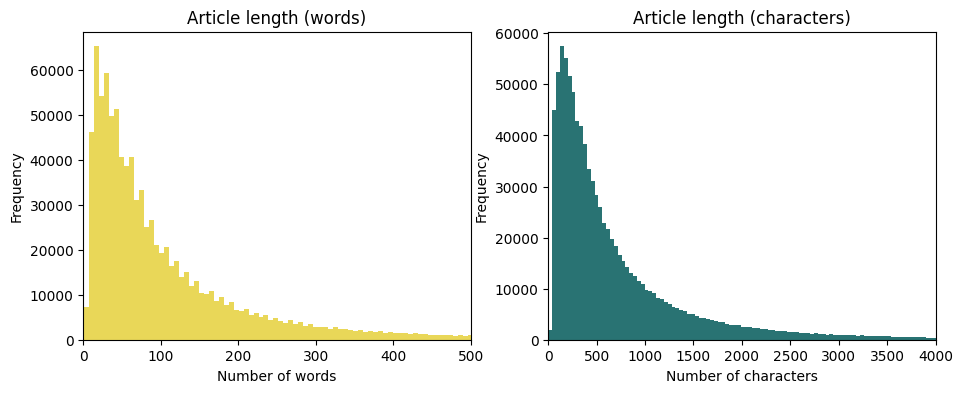

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4), sharex=False)

df['article_length'].plot(kind='hist', bins=800, color='#E9D758', ax=axes[0])
axes[0].set_xlim(0,500)
axes[0].set_title('Article length (words)')
axes[0].set_xlabel('Number of words')
axes[0].set_ylabel('Frequency')

df['characters'].plot(kind='hist', bins=800, color='#297373', ax=axes[1])
axes[1].set_xlim(0,4000)
axes[1].set_title('Article length (characters)')
axes[1].set_xlabel('Number of characters')
axes[1].set_ylabel('Frequency')

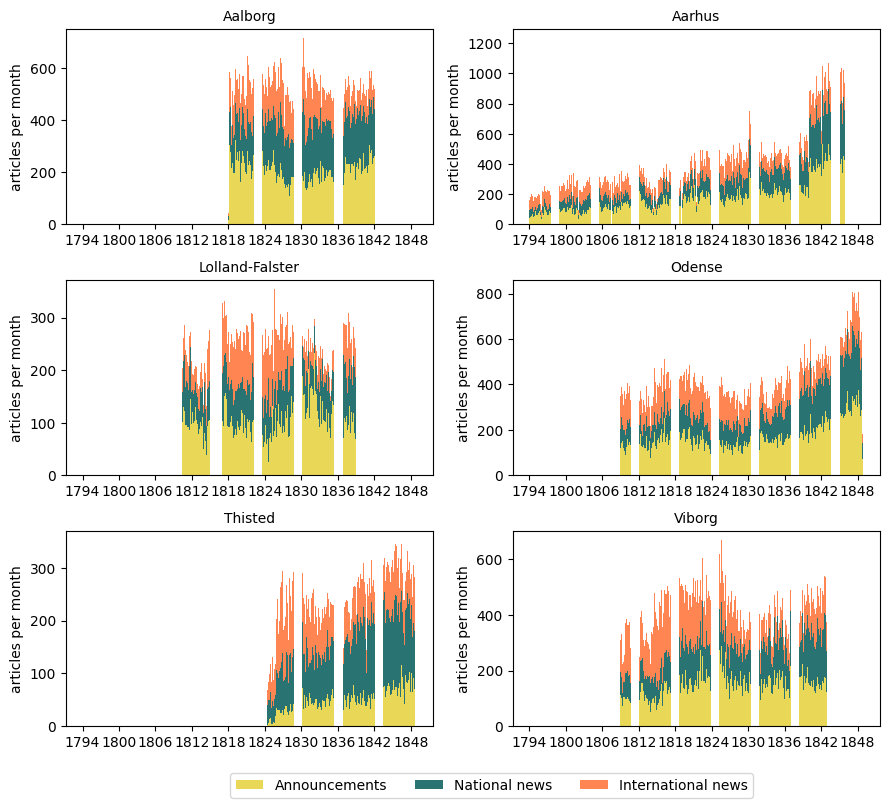

In [ ]:
# Create a figure with 3 rows and 2 columns
fig, axes = plt.subplots(3, 2, figsize=(9, 8))
axes = axes.flatten()

# First January for tick labeling
first_year = next((period.year for period in full_month_range if period.month == 1), None)

# Plot each newspaper
for ax, nsp in zip(axes, unique_newspapers):
    subset = df[df['newspaper'] == nsp].copy()
    subset['date'] = pd.to_datetime(subset['date'])

    # Group by month and category, counting articles
    subset['month'] = subset['date'].dt.to_period('M')
    grouped = subset.groupby(['month', 'clean_category'])['date'].count().unstack(fill_value=0)
    grouped = grouped.reindex(full_month_range, fill_value=0)

    # Plot stacked bars
    bottom = np.zeros(len(grouped))
    for category in grouped.columns:
        ax.bar(
            range(len(grouped)),
            grouped[category],
            bottom=bottom,
            color=category_to_color.get(category, '#999999'),
            label=category
        )
        bottom += grouped[category]

    # X-tick formatting: only show January every 5 years
    tick_positions = []
    tick_labels = []
    for i, period in enumerate(full_month_range):
        if period.month == 1 and ((period.year - first_year) % 6 == 0):
            tick_positions.append(i)
            tick_labels.append(str(period.year))

    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=0)
    ax.set_ylabel('articles per month')
    ax.set_title(f'{newspaper_dict[nsp]}', fontsize=10)

# Add legend (can be moved to a different position if needed)
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(
    handles,
    ['Announcements', 'National news', 'International news'],
    loc='lower right',
    ncol=3,
    bbox_to_anchor=(0.85, -0.05)
)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.savefig('../figures/article_counts_by_category.pdf', bbox_inches='tight')
plt.show()

findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font f

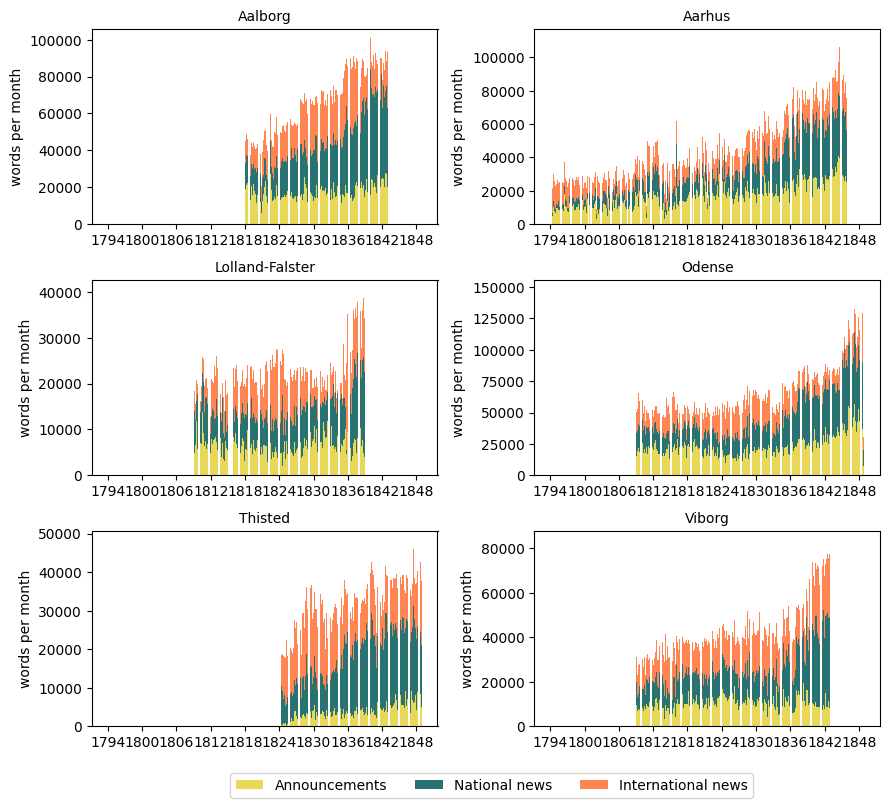

In [ ]:
# Create a figure with 3 rows and 2 columns
fig, axes = plt.subplots(3, 2, figsize=(9, 8))
axes = axes.flatten()

# First January for tick labeling
first_year = next((period.year for period in full_month_range if period.month == 1), None)

# Plot each newspaper
for ax, nsp in zip(axes, unique_newspapers):
    subset = df[df['newspaper'] == nsp].copy()
    subset['date'] = pd.to_datetime(subset['date'])

    # Group by month and category
    subset['month'] = subset['date'].dt.to_period('M')
    grouped = subset.groupby(['month', 'clean_category'])['article_length'].sum().unstack(fill_value=0)
    grouped = grouped.reindex(full_month_range, fill_value=0)

    # Plot stacked bars
    bottom = np.zeros(len(grouped))
    for category in grouped.columns:
        ax.bar(
            range(len(grouped)),
            grouped[category],
            bottom=bottom,
            color=category_to_color.get(category, '#999999'),
            label=category
        )
        bottom += grouped[category]

    # X-tick formatting
    tick_positions = []
    tick_labels = []
    for i, period in enumerate(full_month_range):
        if period.month == 1 and (period.year - first_year) % 6 == 0:
            tick_positions.append(i)
            tick_labels.append(str(period.year))

    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=0)
    ax.set_ylabel('words per month')
    ax.set_title(f'{newspaper_dict[nsp]}', fontsize=10)

# Add legend
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, ['Announcements', 'National news', 'International news'], loc='lower right', ncol=3, bbox_to_anchor=(0.85,-0.05))

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.savefig('../figures/words_month_category.pdf', bbox_inches='tight')
plt.show()

findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.


findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font family 'Tinos' not found.
findfont: Font f

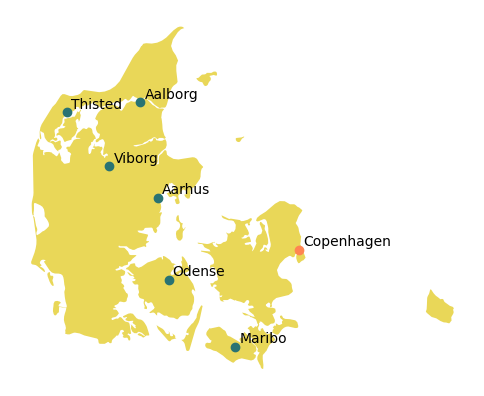

In [15]:
# Map

import geopandas as gpd

dk = gpd.read_file("../data/dk.json")
ax = dk.plot(edgecolor='none', facecolor='#E9D758', figsize=(6,6))

# add cities
cities = {
  "Aarhus": (10.2108, 56.1567),
  "Aalborg": (9.9187, 57.0480),
  "Maribo": (11.5002, 54.7766),
  "Odense": (10.3883, 55.3959),
  "Thisted": (8.6949, 56.9552),
  "Viborg": (9.4020, 56.4532),
  "Copenhagen": (12.5655, 55.6759)
}
for name,(lon,lat) in cities.items():
    if name == 'Copenhagen':
        ax.plot(lon, lat, 'o', color='#FF8552')
        ax.annotate(name, (lon,lat), xytext=(3,3), textcoords='offset points')
    else:
        ax.plot(lon, lat, 'o', color='#297373')
        ax.annotate(name, (lon,lat), xytext=(3,3), textcoords='offset points')
plt.axis('off')
plt.savefig('../figures/map_dk.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# Ensure embeddings are stored as NumPy arrays (if they are lists)
df['embedding'] = df['embedding'].apply(lambda x: np.array(x) if isinstance(x, list) else x)

: 

In [ ]:
# Fit one PCA on all articles

# Stack all embeddings into one matrix
all_embeddings = np.vstack(df['embedding'].values)

# Apply PCA to all embeddings
pca = PCA(n_components=2)
all_embeddings_pca = pca.fit_transform(all_embeddings)

# Add PCA results to the original dataframe
df['PC1'] = all_embeddings_pca[:, 0]
df['PC2'] = all_embeddings_pca[:, 1]

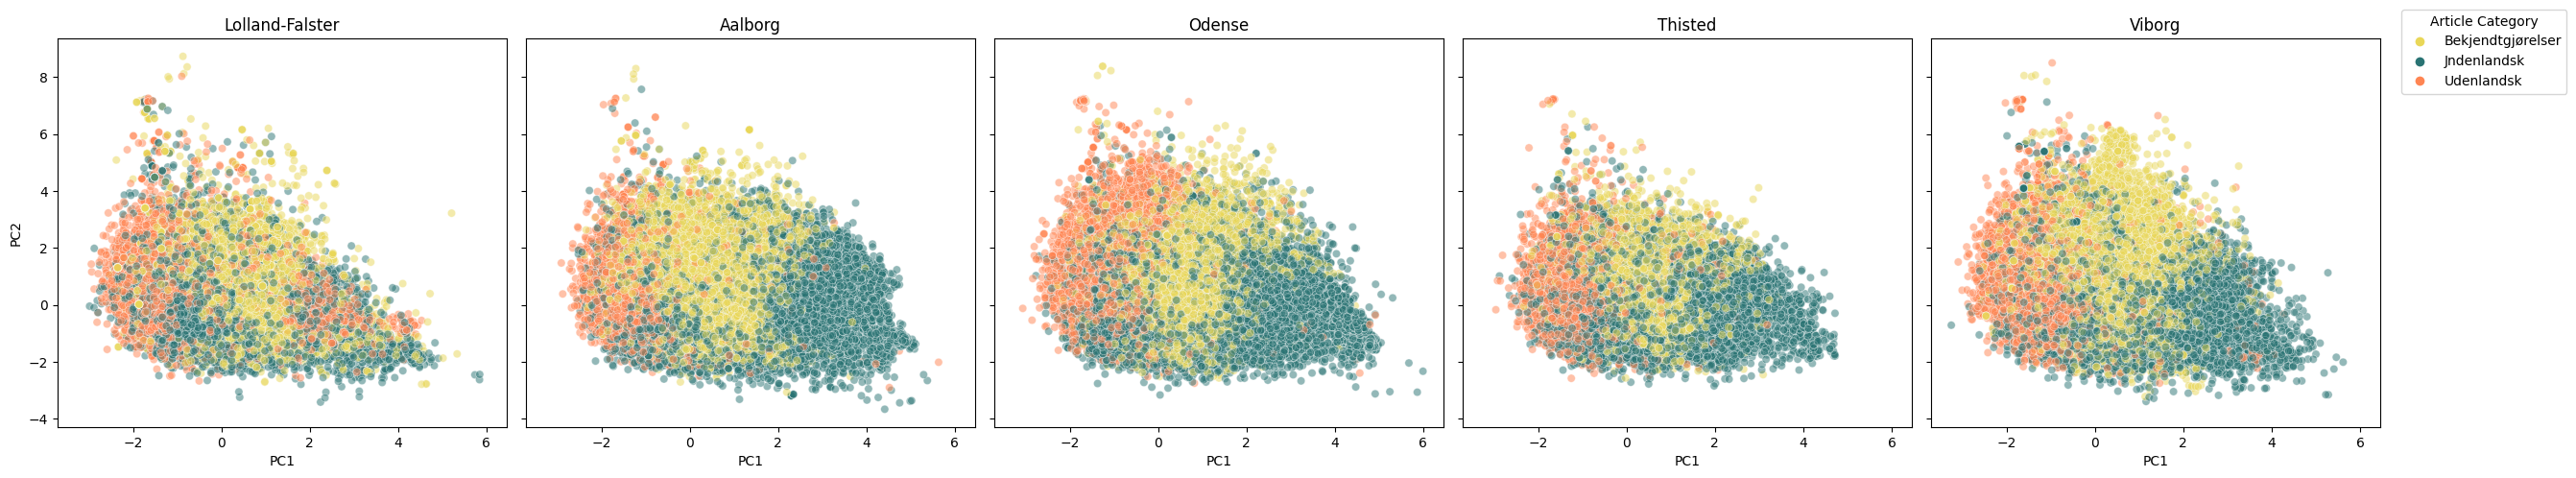

In [ ]:
# Create a figure with subplots (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)

# Loop through each newspaper and plot in a subplot
for i, newspaper in enumerate(unique_newspapers):
    # Filter the DataFrame for the specific newspaper
    df_filtered = df[df['newspaper'] == newspaper]

    # Plot the shared PCA projection
    ax = axes[i]
    sns.scatterplot(
        x='PC1', y='PC2', hue='clean_category', data=df_filtered,
        palette=category_to_color, alpha=0.5, ax=ax
    )
    ax.set_title(f"{newspaper_dict[newspaper]}")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.legend([], [], frameon=False)  # Remove individual legends

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=cat,
           markerfacecolor=category_to_color[cat], markersize=8)
    for cat in all_categories
]
fig.legend(legend_elements, all_categories, title="Article Category", bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
#plt.savefig('../figures/PCA_e5_full_fit.jpg', bbox_inches='tight', dpi=300)
plt.show()

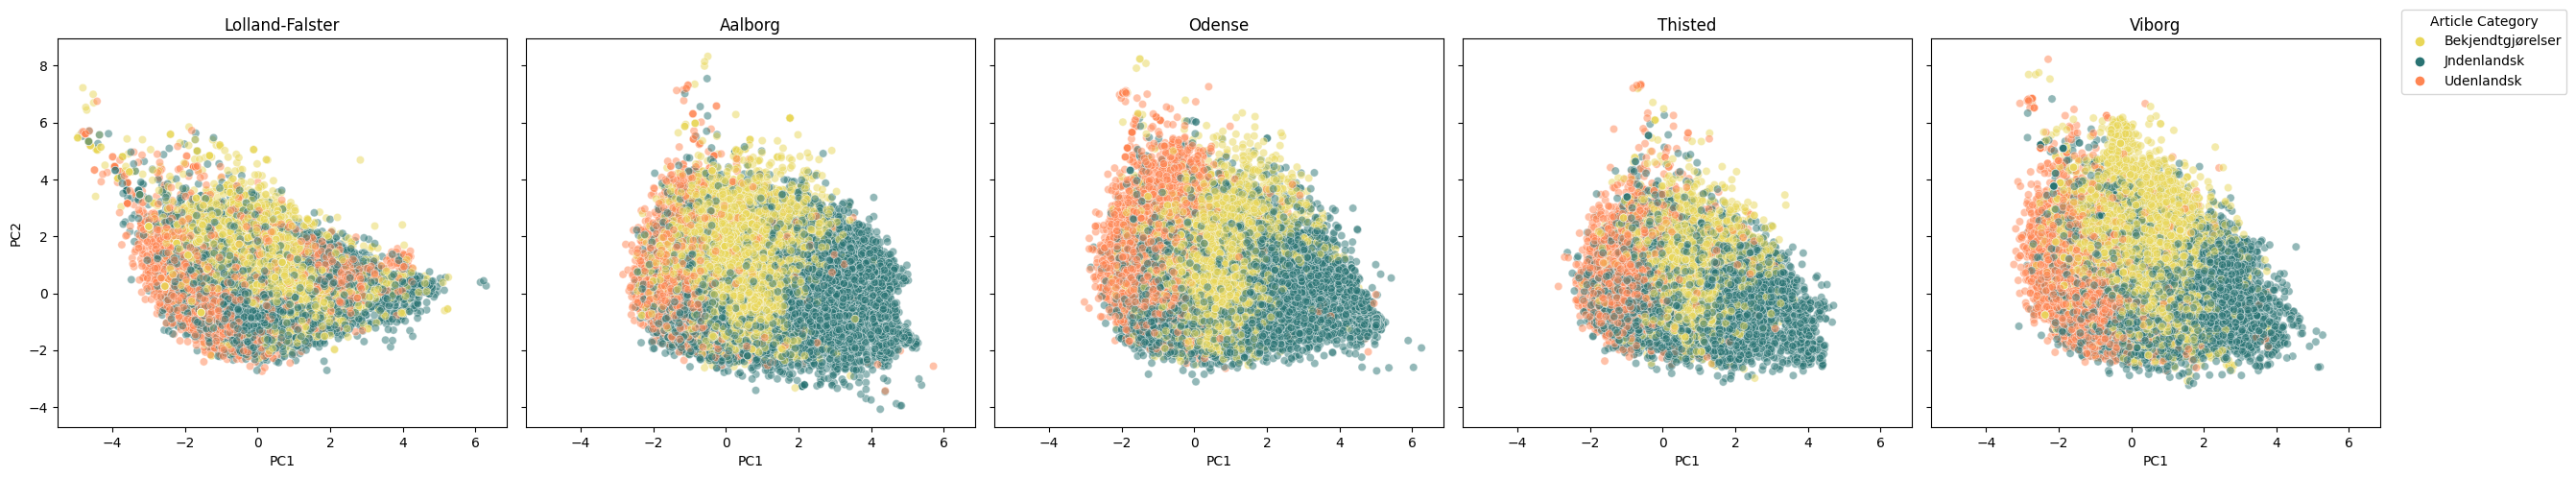

In [23]:
# Fit separate PCA for each newspaper

# Create a figure with subplots (1 row, 5 columns)
fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharex=True, sharey=True)

# Loop through each newspaper and plot in a subplot
for i, newspaper in enumerate(unique_newspapers):
    # Filter the DataFrame for the specific newspaper
    df_filtered = df[df['newspaper'] == newspaper]

    # Skip if there are no embeddings for this newspaper
    if df_filtered.empty:
        continue

    # Stack embeddings into a NumPy array
    embeddings_matrix = np.vstack(df_filtered['embedding'].values)

    # Apply PCA to reduce dimensionality to 2D
    pca = PCA(n_components=2)
    embeddings_pca = pca.fit_transform(embeddings_matrix)

    # Create a DataFrame for visualization
    pca_df = pd.DataFrame(embeddings_pca, columns=['PC1', 'PC2'])
    pca_df['clean_category'] = df_filtered['clean_category'].values  # Assign categories

    # Plot the PCA results in a subplot
    ax = axes[i]
    sns.scatterplot(
        x='PC1', y='PC2', hue='clean_category', data=pca_df, palette=category_to_color, alpha=0.5, ax=ax
    )
    ax.set_title(f"{newspaper_dict[newspaper]}")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.legend([], [], frameon=False)  # Remove individual legends

# Adjust layout and show a single legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=cat,
           markerfacecolor=category_to_color[cat], markersize=8)
    for cat in all_categories
]
fig.legend(legend_elements, all_categories, title="Article Category", bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.savefig('../figures/PCA_memo_separate_fit.jpg', bbox_inches='tight', dpi=300)
plt.show()

### Find books in announcements

In [12]:
# Make subset with announcements
df_announcements = df[df['clean_category'] == 'Bekjendtgjørelser']

# Your list of keywords
keywords = ['indb.', 'heftet', 'udkomm', 'udgiv', 'udgav', 'indbund', 'oversatt', 'paa adressekontoiret']

# Build regex: word-start match for most
pattern_parts = [r'\b' + re.escape(word) for word in keywords]

# Add a special rule for 'oplag' to match full word only
pattern_parts.append(r'\boplag\b')

# Combine all into one regex pattern
pattern = '(' + '|'.join(pattern_parts) + ')'

# Filter the DataFrame
boger_df = df_announcements[df_announcements['text'].str.contains(pattern, case=False, na=False)]
boger_df.shape

/tmp/ipykernel_1047/821015693.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  boger_df = df_announcements[df_announcements['text'].str.contains(pattern, case=False, na=False)]


(18442, 13)

In [13]:
boger_df.head()

,article_id,date,embedding,n_chunks_orig,clean_category,nøgle,text,category,article_length,characters,embedding_shape,newspaper,label_type
32,lol_000033,1809-03-07,"[0.024918418377637863, 0.038971804082393646, -...",1,Bekjendtgjørelser,1809-03-07_45,"Bekiendtgiørelser. De Herrer, der have imodtag...",Bekiendtgiørelser,27,209,[1024],lol,gold
37,lol_000038,1809-03-07,"[0.03518466651439667, 0.009328734129667282, -0...",1,Bekjendtgjørelser,1809-03-07_52,Paa Addresse-Contoiret i Mariboe bekommes følg...,Bekiendtgiørelser,76,475,[1024],lol,gold
63,lol_000064,1809-03-10,"[0.02332383394241333, 0.014926900155842304, -0...",2,Bekjendtgjørelser,1809-03-10_89,Paa Addresse=Contoiret i Mariboe bekommes følg...,Bekiendtgiørelser,121,768,[1024],lol,gold
108,lol_000109,1809-03-17,"[0.022117991000413895, 0.003557007061317563, -...",1,Bekjendtgjørelser,1809-03-17_174,Maskeradeballet i Dannemark 1808. Et Syn af N....,Bekiendtgiørelser,84,495,[1024],lol,gold
153,lol_000154,1809-03-24,"[0.0281141996383667, 0.020626125546793144, -0....",3,Bekjendtgjørelser,1809-03-24_255,Som alt var indpakket i et hvidt Hørgarns Lomm...,Bekiendtgiørelser,176,1121,[1024],lol,gold


In [15]:
random_sample = boger_df.sample(n=2000, random_state=42)

In [16]:
random_sample[['article_id', 'date', 'text']].to_csv('../data/random_sample.csv')

In [14]:
boger_df[['article_id', 'date', 'text']].to_csv('../data/boger.csv')

### KeyNMF

In [16]:
# load model with which embeddings are created
trf = SentenceTransformer('intfloat/multilingual-e5-large')

# load stopword list
with open('../../danske-aviser/notebooks/stopwords-da_txt.txt') as file:
    stop_words = file.read().split()

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/160k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

threshold for number of characters vs digits in text

In [58]:
import textdescriptives

ModuleNotFoundError: No module named 'textdescriptives'

In [17]:
# make subset of only one newspaper category
df_indenlandsk = df[df['clean_category'] == 'Bekjendtgjørelser']
df_indenlandsk.shape

# create balanced sample over different newspapers
balanced_df_indenlandsk = df_indenlandsk.groupby('newspaper', group_keys=False).apply(
    lambda x: x.sample(n=500, replace=True) if len(x) >= 200 else x
).reset_index(drop=True)
balanced_df_indenlandsk.shape

# prepare corpus for KeyNMF
corpus = balanced_df_indenlandsk['text'].tolist()
cleaned_corpus = [remove_tokens_with_digits(text) for text in corpus]

# prepare embeddings for KeyNMF
embeddings_matrix = np.vstack(balanced_df_indenlandsk['embedding'].values)

/tmp/ipykernel_316/3402855461.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df_indenlandsk = df_indenlandsk.groupby('newspaper', group_keys=False).apply(


In [18]:
seeded_model = KeyNMF(10, top_n=15, encoder=trf, vectorizer=CountVectorizer(stop_words=stop_words, min_df=50, max_df=0.85), seed_phrase='Hvilke bøger er til salg?', random_state=42)
seeded_model.fit(cleaned_corpus, embeddings=embeddings_matrix)

Output()

[14:54:24] Keyword extraction done.                                                                   ]8;id=775370;file:///home/ucloud/.local/lib/python3.12/site-packages/turftopic/models/keynmf.py\keynmf.py]8;;\:]8;id=885029;file:///home/ucloud/.local/lib/python3.12/site-packages/turftopic/models/keynmf.py#219\219]8;;\

           Model fitting done.                                                                        ]8;id=317996;file:///home/ucloud/.local/lib/python3.12/site-packages/turftopic/models/keynmf.py\keynmf.py]8;;\:]8;id=683502;file:///home/ucloud/.local/lib/python3.12/site-packages/turftopic/models/keynmf.py#226\226]8;;\

KeyNMF(encoder=SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: XLMRobertaModel 
  (1): Pooling({'word_embedding_dimension': 1024, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': F...
       n_components=10, random_state=42,
       seed_phrase='Hvilke bøger er til salg?', top_n=15,
       vectorizer=CountVectorizer(max_df=0.85, min_df=50,
                                  stop_words=['ad', 'af', 'aldrig', 'alle',
                                              'alt', 'anden', 'andet', 'andre',
                                              'at', 'bare', 'begge', 'blev',
                                              'bleven', 'blive', 'bliver', 'da',
                                              'de', 'dem', 'den', 'denne',
                                              'dennes', 'der', 'deres', 'det',
                                              'dette', 'dig', 'din', 'dine',
                                              'disse', 'dit', ...]))

In [19]:
seeded_model.print_topics() # seed

┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Topic ID ┃ Highest Ranking                                                                                      ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        0 │ auction, offentlig, bestaaende, sengeklæder, afholdt, bortsælge, bortsolgt, næstkommende, byen,      │
│          │ auctionsstedet                                                                                       │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        1 │ varsel, anmelde, indkaldes, beviisliggjøre, afdøde, skifteforvalter, fordringer, proclama,           │
│          │ vedkommende, ugers                                                                                   │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        2 │ undertegnede, henvende, anbefaler, modtages, tillige, sikkerhed, erholdes, ønske, bortsælge,         │
│          │ underhaanden                                                                                         │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        3 │ tilhørende, afholdes, beliggende, gaard, auctioner, første, gaarden, sogn, eiendommen, tilliggende   │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        4 │ bekjendtgjøres, efterretning, vedkommende, vedkommendes, odense, afholdes, raadstue, kjøbmand,       │
│          │ afholdt, avertissements                                                                              │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        5 │ thisted, lund, forsendes, allernaadigst, privilegerede, brevposten, kongelig, avertissements,        │
│          │ danmark, bemærkes                                                                                    │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        6 │ conditionerne, lysthavende, indbydes, eftersyn, auctionen, erfares, afholdes, auctionsstedet,        │
│          │ contoir, møde                                                                                        │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        7 │ dage, inden, sølv, rbd, bør, vedkommende, første, ere, kongelige, betale                             │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        8 │ førstkommende, foretaget, møde, bemeldte, afholdt, odense, licitation, vedkommendes, gaard,          │
│          │ tilhørende                                                                                           │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        9 │ tilkjøbs, odense, gode, erholdes, priser, erholde, billige, billig, henvende, henvender              │
└──────────┴──────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [20]:
seedless_model = KeyNMF(10, top_n=15, encoder=trf, vectorizer=CountVectorizer(stop_words=stop_words, min_df=50, max_df=0.85), random_state=42)
seedless_model.fit(cleaned_corpus, embeddings=embeddings_matrix)

Output()

[15:32:30] Keyword extraction done.                                                                   ]8;id=412750;file:///home/ucloud/.local/lib/python3.12/site-packages/turftopic/models/keynmf.py\keynmf.py]8;;\:]8;id=812829;file:///home/ucloud/.local/lib/python3.12/site-packages/turftopic/models/keynmf.py#219\219]8;;\

           Model fitting done.                                                                        ]8;id=101266;file:///home/ucloud/.local/lib/python3.12/site-packages/turftopic/models/keynmf.py\keynmf.py]8;;\:]8;id=623006;file:///home/ucloud/.local/lib/python3.12/site-packages/turftopic/models/keynmf.py#226\226]8;;\

KeyNMF(encoder=SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: XLMRobertaModel 
  (1): Pooling({'word_embedding_dimension': 1024, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': F...e_prompt': True})
  (2): Normalize()
),
       n_components=10, random_state=42, top_n=15,
       vectorizer=CountVectorizer(max_df=0.85, min_df=50,
                                  stop_words=['ad', 'af', 'aldrig', 'alle',
                                              'alt', 'anden', 'andet', 'andre',
                                              'at', 'bare', 'begge', 'blev',
                                              'bleven', 'blive', 'bliver', 'da',
                                              'de', 'dem', 'den', 'denne',
                                              'dennes', 'der', 'deres', 'det',
                                              'dette', 'dig', 'din', 'dine',
                                              'disse', 'dit', ...]))

In [21]:
seedless_model.print_topics() # seed

┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Topic ID ┃ Highest Ranking                                                                                      ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        0 │ auction, offentlig, bestaaende, sengeklæder, afholdt, bortsælge, bortsolgt, næstkommende, byen,      │
│          │ auctionsstedet                                                                                       │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        1 │ varsel, anmelde, indkaldes, beviisliggjøre, afdøde, skifteforvalter, fordringer, proclama, ugers,    │
│          │ vedkommende                                                                                          │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        2 │ undertegnede, henvende, anbefaler, modtages, tillige, sikkerhed, erholdes, ønske, bortsælge,         │
│          │ underhaanden                                                                                         │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        3 │ tilhørende, afholdes, beliggende, gaard, auctioner, første, gaarden, sogn, eiendommen, tilliggende   │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        4 │ bekjendtgjøres, efterretning, vedkommende, vedkommendes, odense, afholdes, raadstue, avertissements, │
│          │ kjøbmand, afholdt                                                                                    │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        5 │ thisted, forsendes, lund, allernaadigst, privilegerede, brevposten, kongelig, avertissements,        │
│          │ danmark, bemærkes                                                                                    │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        6 │ conditionerne, lysthavende, indbydes, eftersyn, auctionen, erfares, afholdes, auctionsstedet,        │
│          │ contoir, møde                                                                                        │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        7 │ dage, inden, sølv, rbd, bør, vedkommende, ere, kongelige, første, betale                             │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        8 │ førstkommende, foretaget, møde, bemeldte, afholdt, odense, licitation, vedkommendes, gaard,          │
│          │ tilhørende                                                                                           │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        9 │ tilkjøbs, odense, gode, erholdes, priser, erholde, billige, henvende, billig, henvender              │
└──────────┴──────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [22]:
print(np.allclose(seeded_model.components_, seedless_model.components_))

False
